In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# # import os
# # for dirname, _, filenames in os.walk('/kaggle/input'):
# #     for filename in filenames:
# #         path=os.path.join(dirname, filename)

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%%capture

!pip install /kaggle/input/rsnamodules/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl 

try:
    import pylibjpeg
except:
   !pip install /kaggle/input/rsna-2022-whl/{pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}

In [3]:
!pip install -qU python-gdcm pydicom pylibjpeg

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [4]:
pip install dicomsdl

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import numpy as np
import pandas as pd
import shutil 
import math
import glob
import cv2

from tqdm import tqdm
from joblib import Parallel, delayed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
import pydicom

In [7]:
#!pip install opencv-python

In [8]:
# Load train and test csv files\
train_csv=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
test_csv=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')

In [9]:

# Get the data path
data_path='/kaggle/input/rsna-breast-cancer-512-pngs'

In [10]:
# Count the number of images 
current_dir = os.getcwd()
print(current_dir)

/kaggle/working


# EDA

# Preparation

In [11]:
if not os.path.exists(os.path.join(current_dir,'input_transformed')):
    os.mkdir(os.path.join(current_dir,'input_transformed'))

if not os.path.exists(os.path.join(current_dir,'input_transformed','0')):
    os.mkdir(os.path.join(current_dir,'input_transformed','0'))

if not os.path.exists(os.path.join(current_dir,'input_transformed','1')):
    os.mkdir(os.path.join(current_dir,'input_transformed','1'))

### I will undersample train data with negative case

In [12]:
train_neg=train_csv[train_csv.cancer==0].sample(n=1000)
train_neg

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
9119,1,19759,986903848,R,CC,47.0,0,0,0,1.0,0,C,49,False
34233,2,46737,546098747,R,MLO,59.0,0,0,0,NaN,0,NaN,21,False
20223,2,31440,1139839119,R,MLO,54.0,0,0,0,NaN,0,NaN,21,False
33742,1,46206,520705659,L,MLO,59.0,0,0,0,NaN,0,C,93,False
51370,2,65364,2117849470,R,MLO,59.0,0,0,0,NaN,0,NaN,21,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37283,2,5,1351088028,L,CC,68.0,0,0,0,0.0,0,NaN,21,True
5759,1,16198,345242790,R,CC,70.0,0,0,0,0.0,0,A,49,True
23885,2,35489,1632604308,R,MLO,73.0,0,0,0,NaN,0,NaN,21,False
1546,2,11661,1705275223,L,MLO,73.0,0,0,0,NaN,0,NaN,29,False


In [13]:
train_sample=pd.concat([train_neg,train_csv[train_csv.cancer==1]])
train_sample.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
9119,1,19759,986903848,R,CC,47.0,0,0,0,1.0,0,C,49,False
34233,2,46737,546098747,R,MLO,59.0,0,0,0,NaN,0,NaN,21,False
20223,2,31440,1139839119,R,MLO,54.0,0,0,0,NaN,0,NaN,21,False
33742,1,46206,520705659,L,MLO,59.0,0,0,0,NaN,0,C,93,False
51370,2,65364,2117849470,R,MLO,59.0,0,0,0,NaN,0,NaN,21,False


In [14]:
def crop_image(image_path):
    # Read the input image
    img = cv2.imread(image_path)
    
    # Preprocess the image by normalizing, thresholding, and finding the largest contour
    img_norm = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    gray = cv2.cvtColor(img_norm, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Crop the image using the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]
    resized=cv2.resize(cropped,(256,256))
    return resized

In [15]:
p_id = train_sample.patient_id
i_id = train_sample.image_id
label = train_sample.cancer

for i, j, k in tqdm(zip(p_id, i_id, label)):
    # Construct the paths to the input and output files
    tmpFile = str(i) + '_' + str(j) + '.png'
    tmpSrc = '/kaggle/input/rsna-breast-cancer-512-pngs/' + tmpFile
    tmpDst = '/kaggle/working/input_transformed/' + str(k) + '/' + tmpFile
    
    # cropped input image
    cropped=crop_image(tmpSrc)
    
    # Save the cropped image to the output directory
    cv2.imwrite(tmpDst, cropped)


2158it [00:45, 47.66it/s]


In [16]:
batch_size=32
train_ds=tf.keras.preprocessing.image_dataset_from_directory('/kaggle/working/input_transformed',
                                                             labels='inferred',
                                                            color_mode='rgb',
                                                            image_size=(512,512),
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            subset='training',
                                                             batch_size=batch_size,
                                                            seed=2023)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/input_transformed/",
    labels='inferred',
    color_mode='rgb',
    image_size=(512, 512),
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    batch_size=batch_size,
    seed=2023)

Found 2158 files belonging to 2 classes.
Using 1727 files for training.
Found 2158 files belonging to 2 classes.
Using 431 files for validation.


In [17]:
class_names=train_ds.class_names
print(class_names)

['0', '1']


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Visualize the data

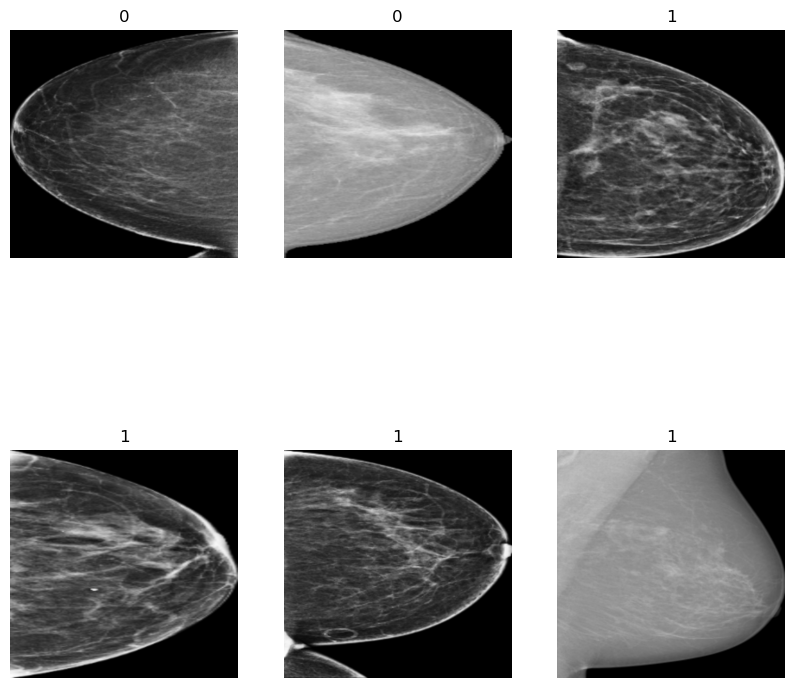

In [19]:
# first 6 images in the training dataset:
import matplotlib.pyplot as plt 
plt.figure (figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax=plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Configure the dataset for performance
Use buffered prefetchin t yield data from disk without having I/O become blocking. There are two important methods you should use when loading data:
- Dataset.cache: keeps the images in memory after they are loaded off disk during first epoch. This will ensure the dataset doesn't become a bottleneck while training the model. If the dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- Dataset.prefetch overlaps data preprocessing and model execution while training.

In [20]:
# Standardize the data
normalization_layer=layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9156863


In [21]:
first_image

<tf.Tensor: shape=(512, 512, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.1892157 , 0.1892157 , 0.1892157 ],
        [0.19117649, 0.19117649, 0.19117649],
        [0.19215688, 0.19215688, 0.19215688]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.2019608 , 0.2019608 , 0.2019608 ],
        [0.20588237, 0.20588237, 0.20588237],
        [0.20784315, 0.20784315, 0.20784315]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.227451  , 0.227451  , 0.227451  ],
        [0.23529413, 0.23529413, 0.23529413],
        [0.2392157 , 0.2392157 , 0.2392157 ]],

       ...,

       [[0.7441177 , 0.7441177 , 0.7441177 ],
        [0.75

# A basic Keras model
## Create the model

In [22]:
img_height,img_width=512,512
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
54/54 [==============================] - 29s 291ms/step - loss: 7.1110 - accuracy: 0.4702 - val_loss: 6.5809 - val_accuracy: 0.4316
Epoch 2/10
54/54 [==============================] - 15s 255ms/step - loss: 7.1875 - accuracy: 0.4713 - val_loss: 6.5809 - val_accuracy: 0.4316
Epoch 3/10
54/54 [==============================] - 16s 272ms/step - loss: 7.1875 - accuracy: 0.4713 - val_loss: 6.5809 - val_accuracy: 0.4316
Epoch 4/10
54/54 [==============================] - 15s 264ms/step - loss: 7.1875 - accuracy: 0.4713 - val_loss: 6.5809 - val_accuracy: 0.4316
Epoch 5/10
54/54 [==============================] - 15s 257ms/step - loss: 7.1875 - accuracy: 0.4713 - val_loss: 6.5809 - val_accuracy: 0.4316
Epoch 6/10
54/54 [==============================] - 16s 268ms/step - loss: 7.1875 - accuracy: 0.4713 - val_loss: 6.5809 - val_accuracy: 0.4316
Epoch 7/10
54/54 [==============================] - 15s 254ms/step - loss: 7.1875 - accuracy: 0.4713 - val_loss: 6.5809 - val_accuracy: 0.4316

# Visualizing training results

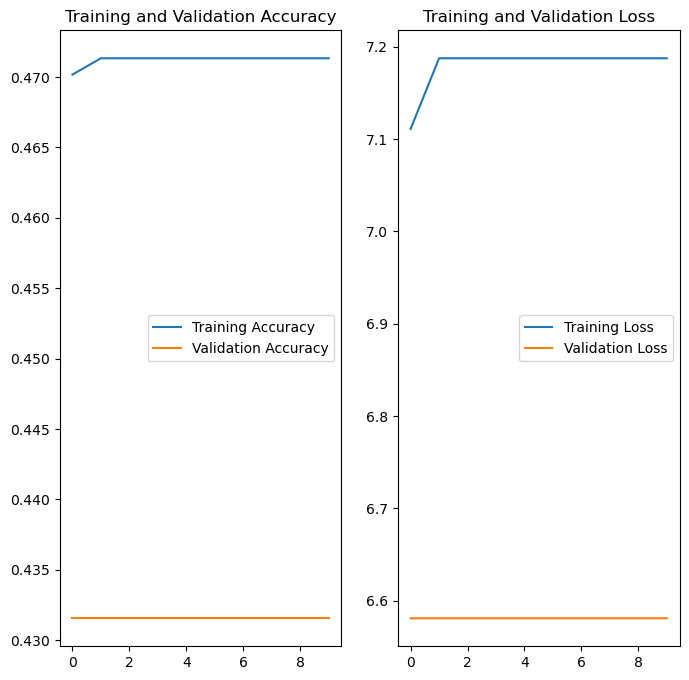

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Overfitting
It can clearly be seen that the model didn't learn and there is overfitting. Next, I will apply data augmentation.

# Data Augmentation

In [27]:
IMG_SIZE = 512
batch_size = 32
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.3),
  layers.RandomRotation(20),
    layers.RandomZoom(0.1),
])

# visualizating augmented images

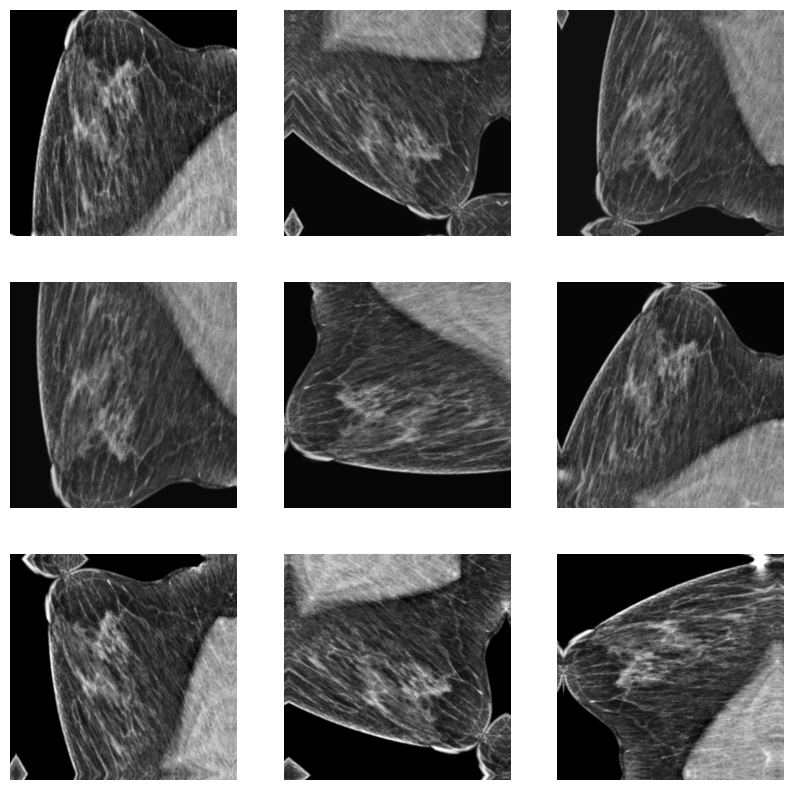

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model

In [29]:
model= Sequential([
  resize_and_rescale,data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
import keras.backend as K

def f2_score(y_true, y_pred):
    beta = 2
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + K.epsilon())

In [32]:
# def Fscore_metric(labels, preds, beta=1):
#     preds = tf.clip_by_value(preds, 0, 1)
#     y_true_count = tf.reduce_sum(labels)
#     ctp = tf.reduce_sum(preds[(labels == tf.cast(1, labels.dtype))])
#     cfp = tf.reduce_sum(preds[(labels == tf.cast(0, labels.dtype))])
#     beta_squared = beta * beta
#     precision = ctp / (ctp + cfp + tf.keras.backend.epsilon())
#     recall = ctp / (y_true_count + tf.keras.backend.epsilon())
#     fscore = (1 + beta_squared) * ((precision * recall) / ((beta_squared * precision) + recall + tf.keras.backend.epsilon()))
#     return fscore

## Early stopping and model check point

In [33]:
# from keras.callbacks import ModelCheckpoint,EarlyStopping

# # Early stopping
# early_stopping=EarlyStopping(monitor='val_f1_score',min_delta=0.01,patience=10,verbose=1,mode='auto')

# # Checkpoint
# checkpoint=ModelCheckpoint(monotor='val_f1_score',filepath='./bestmodel.h5',save_best_only=True,verbose=1,mode='auto')
# callback=[early_stopping,checkpoint]

In [34]:
# history=model.fit_generator(generator=train_data,
#                             steps_per_epoch=8,
#                             epochs=30,
#                             verbose=1,
#                             validation_data=val_data,
#                             validation_steps=16,
#                             callbacks=callback)

In [35]:
epochs=10
history=model.fit(
train_ds,
validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
54/54 [==============================] - 30s 478ms/step - loss: 7.1246 - accuracy: 0.5258 - val_loss: 6.5809 - val_accuracy: 0.5684
Epoch 2/10
54/54 [==============================] - 26s 464ms/step - loss: 7.1875 - accuracy: 0.5287 - val_loss: 6.5809 - val_accuracy: 0.5684
Epoch 3/10
54/54 [==============================] - 27s 467ms/step - loss: 7.1875 - accuracy: 0.5287 - val_loss: 6.5809 - val_accuracy: 0.5684
Epoch 4/10
54/54 [==============================] - 26s 462ms/step - loss: 7.1875 - accuracy: 0.5287 - val_loss: 6.5809 - val_accuracy: 0.5684
Epoch 5/10
54/54 [==============================] - 27s 469ms/step - loss: 7.1875 - accuracy: 0.5287 - val_loss: 6.5809 - val_accuracy: 0.5684
Epoch 6/10
54/54 [==============================] - 27s 467ms/step - loss: 7.1875 - accuracy: 0.5287 - val_loss: 6.5809 - val_accuracy: 0.5684
Epoch 7/10
54/54 [==============================] - 26s 469ms/step - loss: 7.1875 - accuracy: 0.5287 - val_loss: 6.5809 - val_accuracy: 0.5684

In [36]:
model.save('rsna_train_baseline.h5')

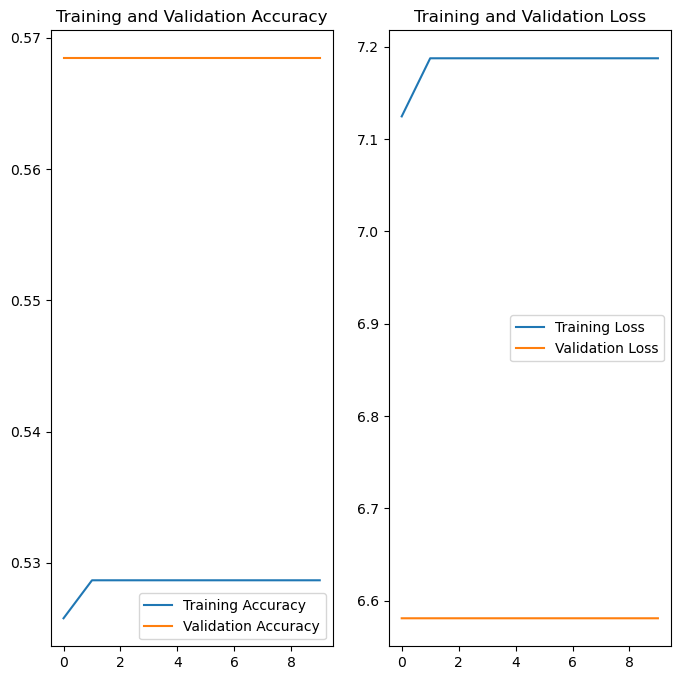

In [37]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Transfer learning and fine-tuning:

# MobileNet 

## Rescale pixel values
I will use MobileNetV2 as base model.This model expects pixel values in [-1,1], and we need to rescale [0,255].

In [38]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [39]:
rescale=tf.keras.layers.Rescaling(1/127.5, offset=-1)

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [40]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE=(512,512)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [41]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 16, 16, 1280)


### Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [42]:
base_model.trainable = False

In [43]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [45]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [46]:
inputs = tf.keras.Input(shape=(512,512, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model
Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [47]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 512, 512, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 16, 16, 1280)     2257984   
 ional)                                                          
                                                             

In [49]:
len(model.trainable_variables)

2

### Train the model

In [50]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

14/14 [==============================] - 7s 274ms/step - loss: 0.8008 - accuracy: 0.4316


In [51]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 35s 554ms/step - loss: 0.7349 - accuracy: 0.5119 - val_loss: 0.6944 - val_accuracy: 0.4408
Epoch 2/10
54/54 [==============================] - 30s 539ms/step - loss: 0.7332 - accuracy: 0.4986 - val_loss: 0.6886 - val_accuracy: 0.4571
Epoch 3/10
54/54 [==============================] - 30s 540ms/step - loss: 0.7306 - accuracy: 0.4922 - val_loss: 0.6840 - val_accuracy: 0.4594
Epoch 4/10
54/54 [==============================] - 30s 537ms/step - loss: 0.7252 - accuracy: 0.4922 - val_loss: 0.6864 - val_accuracy: 0.4524
Epoch 5/10
54/54 [==============================] - 30s 531ms/step - loss: 0.7222 - accuracy: 0.4876 - val_loss: 0.6829 - val_accuracy: 0.4594
Epoch 6/10
54/54 [==============================] - 30s 541ms/step - loss: 0.7305 - accuracy: 0.4997 - val_loss: 0.6795 - val_accuracy: 0.4780
Epoch 7/10
54/54 [==============================] - 30s 539ms/step - loss: 0.7202 - accuracy: 0.5084 - val_loss: 0.6799 - val_accuracy: 0.4710

Obtained accuracy of only 0.4316

### Fine tuning
In the feature extraction experiment, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

###  Un-freeze the top layers of the model

In [52]:
base_model.trainable=True

In [53]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 125

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [54]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 512, 512, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 16, 16, 1280)     2257984   
 ional)                                                          
                                                             

In [56]:
len(model.trainable_variables)

32

In [57]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
54/54 [==============================] - 39s 597ms/step - loss: 0.7104 - accuracy: 0.4991 - val_loss: 0.6724 - val_accuracy: 0.4826
Epoch 11/20
54/54 [==============================] - 32s 570ms/step - loss: 0.6897 - accuracy: 0.5206 - val_loss: 0.6722 - val_accuracy: 0.4594
Epoch 12/20
54/54 [==============================] - 32s 571ms/step - loss: 0.6906 - accuracy: 0.5014 - val_loss: 0.6704 - val_accuracy: 0.4571
Epoch 13/20
54/54 [==============================] - 32s 570ms/step - loss: 0.6843 - accuracy: 0.5049 - val_loss: 0.6710 - val_accuracy: 0.5684
Epoch 14/20
54/54 [==============================] - 32s 574ms/step - loss: 0.6808 - accuracy: 0.5177 - val_loss: 0.6702 - val_accuracy: 0.4478
Epoch 15/20
54/54 [==============================] - 32s 566ms/step - loss: 0.6783 - accuracy: 0.5032 - val_loss: 0.6670 - val_accuracy: 0.5824
Epoch 16/20
54/54 [==============================] - 32s 569ms/step - loss: 0.6793 - accuracy: 0.5177 - val_loss: 0.6620 - val_accuracy:

In [58]:
acc+=history_fine.history['accuracy']
val_acc+=history_fine.history['val_accuracy']
loss+=history_fine.history['loss']
val_loss+=history_fine.history['val_loss']

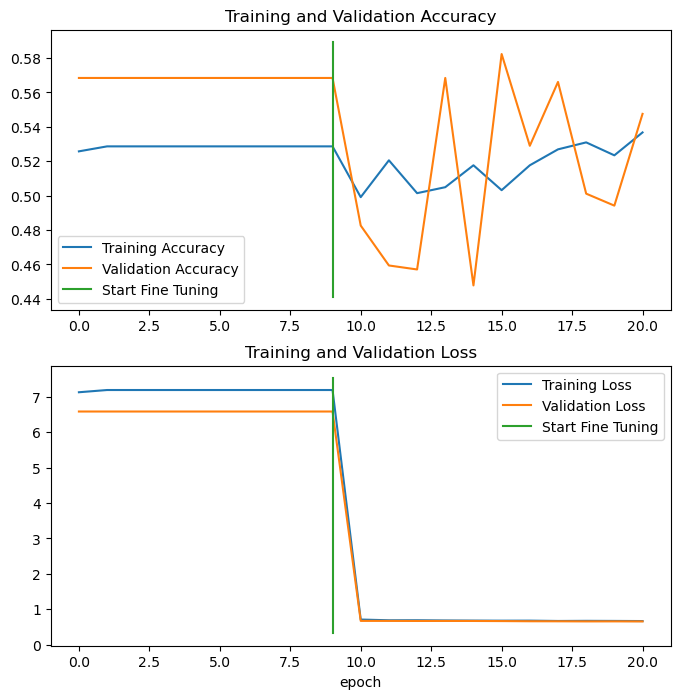

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0., 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Further understanding

In [60]:
layer=keras.layers.Dense(3)
layer.build((None,4))
print('weights:',len(layer.weights))
print('trainable_weights:',len(layer.trainable_weights))
print('non-trainable_weights:',len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non-trainable_weights: 0


In [61]:
base_xception=keras.applications.Xception(
weights='imagenet',
input_shape=(512,512,3),
include_top=False) # Do not include  the imagenet clasifier at the top

83683744/83683744 [==============================] - 1s 0us/step


In [62]:
# Freeze the base model
base_xception.trainable=False

In [63]:
inputs=keras.Input(shape=(512,512,3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x=base_xception(inputs,training=False)
# convert features of shape 'base_xception.output_shape[1:] to vectors
x=keras.layers.GlobalAveragePooling2D()(x)
# A dense classifier with a single unit (binary classificaiton)
outputs=keras.layers.Dense(1)(x)
model=keras.Model(inputs,outputs)

In [64]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
54/54 [==============================] - 63s 1s/step - loss: 1.6042 - binary_accuracy: 0.4881 - val_loss: 1.0080 - val_binary_accuracy: 0.5058
Epoch 2/20
54/54 [==============================] - 51s 921ms/step - loss: 1.0876 - binary_accuracy: 0.5327 - val_loss: 0.8970 - val_binary_accuracy: 0.5986
Epoch 3/20
54/54 [==============================] - 52s 933ms/step - loss: 0.9360 - binary_accuracy: 0.5356 - val_loss: 0.9692 - val_binary_accuracy: 0.5568
Epoch 4/20
54/54 [==============================] - 51s 924ms/step - loss: 0.8846 - binary_accuracy: 0.5559 - val_loss: 0.8960 - val_binary_accuracy: 0.5383
Epoch 5/20
54/54 [==============================] - 52s 946ms/step - loss: 0.8481 - binary_accuracy: 0.5605 - val_loss: 0.8448 - val_binary_accuracy: 0.5406
Epoch 6/20
54/54 [==============================] - 51s 922ms/step - loss: 0.8306 - binary_accuracy: 0.5680 - val_loss: 0.8518 - val_binary_accuracy: 0.5499
Epoch 7/20
54/54 [==============================] - 51s 932ms

In [65]:
model.save('base_xception_ep20.h5')

### Fine tuning

In [66]:
# # Unfreeze the base model
# base_xception.trainable=True
# # It's important to recompile your model after you make any changes
# # to the `trainable` attribute of any inner layer, so that your changes
# # are take into account

# inputs=keras.Input(shape=(512,512,3))
# # We make sure that the base_model is running in inference mode here,
# # by passing `training=False`. This is important for fine-tuning, as you will
# # learn in a few paragraphs.
# x=base_xception(inputs,training=False)
# # convert features of shape 'base_xception.output_shape[1:] to vectors
# x=keras.layers.GlobalAveragePooling2D()(x)
# # A dense classifier with a single unit (binary classificaiton)
# outputs=keras.layers.Dense(1)(x)
# model=keras.Model(inputs,outputs)
# model.summary()

In [67]:
# model.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=[keras.metrics.BinaryAccuracy()],
# )
# epochs = 10
# model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Prediction and Submission

## Test data prediction

In [68]:
# DEBUG =True

In [69]:
# test_images = glob.glob("/kaggle/input/rsna-breast-cancer-detection/test_images/*/*.dcm")

# if DEBUG:
#     test_images = glob.glob("/kaggle/input/rsna-breast-cancer-detection/train_images/10042/*.dcm")
    
# print("Number of images :", len(test_images))

In [70]:
# SAVE_FOLDER = "/kaggle/tmp/output/"
# SIZE = 512
# EXTENSION = "png"

# os.makedirs(SAVE_FOLDER, exist_ok=True)

In [71]:
# def process(f, size=512, save_folder="", extension="png"):
#     patient = f.split('/')[-2]
#     image = f.split('/')[-1][:-4]

#     dicom = pydicom.dcmread(f)
#     img = dicom.pixel_array

#     img = (img - img.min()) / (img.max() - img.min())

#     if dicom.PhotometricInterpretation == "MONOCHROME1":
#         img = 1 - img

#     img = cv2.resize(img, (size, size))

#     cv2.imwrite(save_folder + f"{patient}_{image}.{extension}", (img * 255).astype(np.uint8))

In [72]:
# _ = Parallel(n_jobs=2)(
#     delayed(process)(uid, size=SIZE, save_folder=SAVE_FOLDER, extension=EXTENSION)
#     for uid in tqdm(test_images)
# )